In [1]:
%pylab inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys

import numpy as np
import pandas as pd
import scanpy as sc #for interface to single cell stuff

import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization

# load the data
dataset_name = 'pbmc3k'
#datapath="C:\\data\\scRNAseq\\" + dataset_name + "\\"
datapath="./"
X = np.load(datapath + dataset_name + '_counts.npy')
gene_names = np.load(datapath + dataset_name + '_genenames.npy', allow_pickle=True)
UMAP =  np.load(datapath + dataset_name + '_UMAP.npy')

P = 2

N_BATCHES = 4
BATCH_SIZE = int(np.floor(X.shape[0]/N_BATCHES))

# normalization for cells, computed using all genes
counts_per_cell = X.sum(1)
after = np.median(np.array(counts_per_cell))
# after=1e4
size_factors = counts_per_cell / after
norm_vals = size_factors

# keep the first D genes
# X = X[:, :D]
# gene_names=gene_names[:D]

#alternative: specify a list of known cell type markers
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
hvgix = pd.Series(gene_names).isin(marker_genes)
X = X[:, hvgix]
gene_names=gene_names[hvgix]

N, D = X.shape
# print(X.shape)
print(f"Total observations={X.shape[0]}, Batch size={BATCH_SIZE}: dropping {X.shape[0]%BATCH_SIZE} observations.")

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': norm_vals
    })

# data = data.shuffle(buffer_size=N+1)
data = data.batch(BATCH_SIZE, drop_remainder=True)

# strategy = tf.distribute.MirroredStrategy()
    # encoder_function=lambda x: tf.math.log(x+1), decoder_function=lambda x: tf.math.exp(x)-1,
    # encoder_function=lambda x: x, decoder_function=lambda x: x,
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    scale_rates=True, 
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)


Populating the interactive namespace from numpy and matplotlib
Total observations=2638, Batch size=659: dropping 2 observations.
Feature dim: 17 -> Latent dim 2


In [2]:
losses = factor.calibrate_advi(
    num_epochs=100, learning_rate=.1, max_decay_steps=100)

waic = factor.waic()

W0604 09:47:44.474848 4544990656 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 52.57016114774694
Epoch 1: average-batch loss: 51.62116982928898 last batch loss: 52.50311318231869
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 51.49633618811342 last batch loss: 52.391716636390754
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 51.39309102708701 last batch loss: 52.23182267887773
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 51.36660539053675 last batch loss: 52.227594458189095
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 51.29504351951786 last batch loss: 52.194209380732865
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 51.236033776526035 last batch loss: 52.11519248176067
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 51.20000970964728 last batch loss: 52.070213695868176
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 51.13547227437772 last batch loss: 52.04219282264152
Saved a checkpoint: ./.tf_c

Epoch 70: average-batch loss: 28.7981485546345 last batch loss: 29.72254802338652
Epoch 71: average-batch loss: 28.76734339117896 last batch loss: 29.725879648418935
Saved a checkpoint: ./.tf_ckpts/chkpt-69
Epoch 72: average-batch loss: 28.760984962319657 last batch loss: 29.647889559928224
Saved a checkpoint: ./.tf_ckpts/chkpt-70
Epoch 73: average-batch loss: 28.74292395235387 last batch loss: 29.677531158583115
Saved a checkpoint: ./.tf_ckpts/chkpt-71
Epoch 74: average-batch loss: 28.734536573299298 last batch loss: 29.67447191301168
Saved a checkpoint: ./.tf_ckpts/chkpt-72
Epoch 75: average-batch loss: 28.71181180399953 last batch loss: 29.635992070529856
Saved a checkpoint: ./.tf_ckpts/chkpt-73
Epoch 76: average-batch loss: 28.717179348273405 last batch loss: 29.63951667195255
Epoch 77: average-batch loss: 28.68939701656744 last batch loss: 29.6289649250014
Saved a checkpoint: ./.tf_ckpts/chkpt-74
Epoch 78: average-batch loss: 28.69420189227941 last batch loss: 29.614186866163646
E

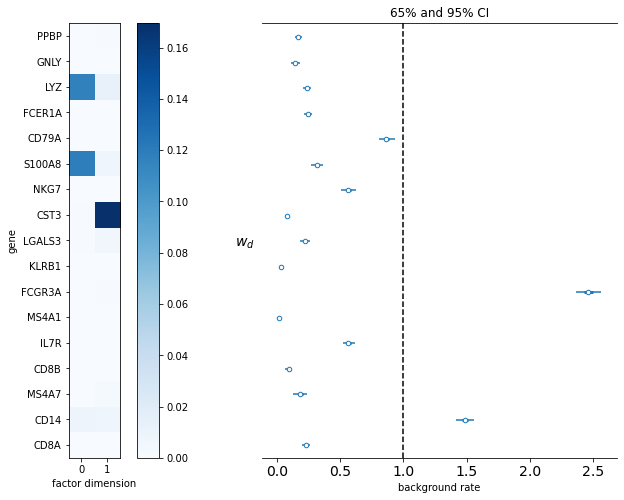

In [3]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
#weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)

encoding_matrix=factor.encoding_matrix().numpy()

# use all genes (with makers)
topix = range(min(len(gene_names),20))

# genes with highest dispersion
# topD = 20
# topix=range(topD)

#try to extract the topD features loaded onto each latent dimension for a plot
# topD=5
# topix=[]
# for d in range(P):
#     thisix=np.argsort(encoding_matrix[:,d])[::-1][:topD]
#     topix+=thisix.tolist()


fig, ax = plt.subplots(1,2, figsize=(14,8))
pcm = ax[0].imshow(encoding_matrix[topix,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(len(topix)))
ax[0].set_yticklabels(gene_names[topix])
ax[0].set_ylabel("gene")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
ID=(tf.squeeze(surrogate_samples['w'])*factor.column_norm_factor).numpy().T #*weights[:,-1,:]
ID=ID[topix,:]
intercept_data = az.convert_to_inference_data({r"$w_d$": ID})
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('rnaseq_factorization.pdf', bbox_inches='tight')
plt.show()

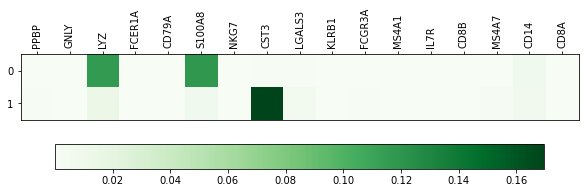

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
pcm = ax.imshow(encoding_matrix.T, cmap="Greens")
plt.colorbar(pcm, orientation='horizontal', ax=ax)

ax.xaxis.set_label_position('top') 
ax.set_xticks(np.arange(len(topix)))
ax.set_xticklabels(gene_names[topix], rotation='vertical')
ax.xaxis.tick_top()
plt.savefig("rnaseq_factorization.pdf", bbox_inches='tight')
plt.show()

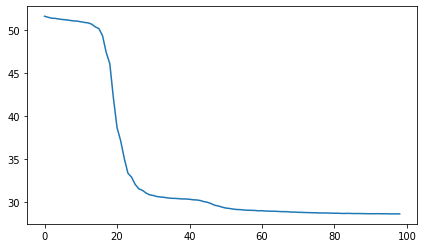

In [4]:
nploss = np.array(losses)
fig = plt.figure(figsize=(7,4))
plt.subplot(111)
plt.plot(nploss)

In [5]:
Z = factor.encode(tf.cast(next(iter(data))['data'], tf.float64))

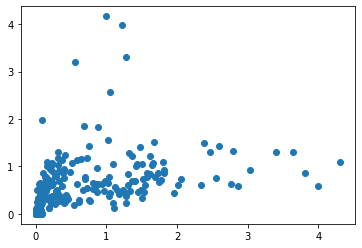

In [6]:
plt.scatter(Z[:,0], Z[:,1])

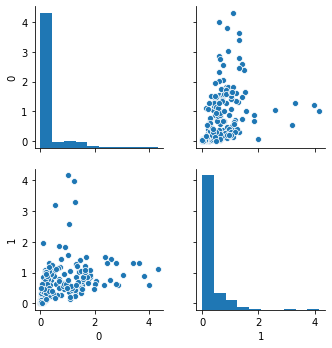

In [7]:
sns.pairplot(pd.DataFrame(Z.numpy()))